In [198]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.stats import kurtosis
import time
import warnings
import datetime
import matplotlib.pylab as plt
import math
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['font.sans-serif'] = ['SimHei']

In [199]:
import pandarallel as pdl
pdl.pandarallel.initialize(10000)

New pandarallel memory created - Size: 10000 MB
Pandarallel will run on 88 workers


In [200]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [379]:
train_df = pd.read_csv('dataset/train.csv', parse_dates=['auditing_date', 'due_date', 'repay_date'])

In [380]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,\N,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [381]:
def plus_1_day(s):
    return s + datetime.timedelta(days=1)

In [382]:
# 如果违约,还款日期为due_date的后一天
train_df['repay_date'] = train_df[['due_date', 'repay_date']].apply(
    lambda x: x['repay_date'] if x['repay_date'] != '\\N' else plus_1_day(x['due_date']), axis=1
)

In [383]:
# 如果违约,还款金额为0
train_df['repay_amt'] = train_df['repay_amt'].apply(lambda x: x if x != '\\N' else 0).astype('float32')

In [384]:
# 设定label
train_df['label'] = (train_df['due_date'] - train_df['repay_date']).dt.days

In [385]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt,label
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.116699,0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.704498,1
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,0.000000,-1
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.980896,0
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.650299,6


In [386]:
train_df['label'].value_counts(sort=False)

 0     408187
 1     121085
 2      59430
 3      56404
 4      26425
 5      21380
 6      17568
 7      14797
 8      12993
 9      11393
 10      9984
 11      9002
 12      8219
 13      7688
 14      6920
 15      6443
 16      6231
 17      5832
 18      5492
 19      5108
 20      4788
 21      4504
 22      4295
 23      4197
 24      3922
 25      3934
 26      3930
 27      4102
 28      4677
 29      5645
 30      9865
 31      8368
-1     117192
Name: label, dtype: int64

In [387]:
train_df['label'].nunique()

33

In [388]:
# 为什么要把-1换作32:方便分类编号和日期对应
# train_df.loc[train_df['repay_amt'] == -1, 'label'] = 32 错误写法
train_df['label'].replace(-1, 32, inplace=True)

In [389]:
clf_labels = train_df['label'].values

In [390]:
clf_labels.shape

(1000000,)

In [391]:
amt_labels = train_df['repay_amt'].values

In [392]:
train_due_amt_df = train_df['due_amt'].values

In [393]:
train_num = train_df.shape[0]

In [394]:
test_df = pd.read_csv('dataset/test.csv', parse_dates=['auditing_date', 'due_date'])

In [395]:
test_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903
1,34524,5443211,2019-03-15,2019-04-15,208.0805
2,821741,5461707,2019-03-22,2019-04-22,421.2097
3,263534,5472320,2019-03-26,2019-04-26,212.6537
4,238853,5459750,2019-03-21,2019-04-21,817.4593


In [396]:
sub = test_df[['user_id', 'listing_id', 'auditing_date', 'due_amt', 'due_date']]

In [397]:
sub.head()

,user_id,listing_id,auditing_date,due_amt,due_date
0,498765,5431438,2019-03-12,138.5903,2019-04-12
1,34524,5443211,2019-03-15,208.0805,2019-04-15
2,821741,5461707,2019-03-22,421.2097,2019-04-22
3,263534,5472320,2019-03-26,212.6537,2019-04-26
4,238853,5459750,2019-03-21,817.4593,2019-04-21


In [398]:
test_df.shape

(130000, 5)

In [399]:
df = pd.concat([train_df.drop(columns=['label','repay_amt','repay_date']), test_df], axis=0, ignore_index=True)

In [400]:
df.shape

(1130000, 5)

In [224]:
df_listing_id = df['listing_id']

In [225]:
# 时间对比控制不用未来的数据
def merge_before_auditing(df, df2, df2_time='info_insert_date', on='user_id'):
    df3 = df.merge(df2, on=on, how='left')
    df4 = df3[(df3['auditing_date']>df3[df2_time])]
    df5 = df.merge(df4, on=df.columns.tolist(), how='left')
    return df5

# *listing_info*

In [226]:
listing_info_df = pd.read_csv('dataset/listing_info.csv', parse_dates=['auditing_date'])

In [227]:
listing_info_df['principal_per_term'] = listing_info_df['principal'] / listing_info_df['term']

In [228]:
listing_info_df.head()

,user_id,listing_id,auditing_date,term,rate,principal,principal_per_term
0,316610,1556649,2017-11-26,9,7.6,4800,533.333333
1,62002,1556633,2017-11-26,6,7.6,4000,666.666667
2,192135,1556629,2017-11-26,12,8.0,8660,721.666667
3,487382,1556628,2017-11-26,9,7.6,4780,531.111111
4,235186,1556627,2017-11-26,9,7.6,1480,164.444444


## 历史贷款信息的统计特征

In [229]:
listing_hist_df = listing_info_df.drop(columns=['listing_id'])
listing_hist_df.rename({'auditing_date': 'hist_auditing_date'},axis=1,inplace=True)

In [230]:
df = merge_before_auditing(df, listing_hist_df, df2_time='hist_auditing_date', on="user_id")

In [231]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667


In [232]:
# 总估算利息
df['interest']=(1+df['term'])*df['principal']*df['rate']/24

In [233]:
groups = df.groupby('listing_id', as_index=False)

In [234]:
# 历史借款数
df = df.merge(groups['principal'].agg({'hist_loans': len}))

In [235]:
# 'pricipal'为空时历史借款数为0
df.loc[df['principal'].isnull(),'hist_loans']=0

In [236]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term,interest,hist_loans
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000,5450.250000,1.0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333,12926.666667,9.0
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000,3510.000000,9.0
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000,2280.000000,9.0
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667,5668.833333,9.0


In [237]:
# 历史总估算利息统计
df = df.merge(groups['interest'].agg({
    'hist_interest_mean':'mean', 'hist_interest_median':'median', 'hist_interest_std':'std', 'hist_interest_max':'max', 
    'hist_interest_min':'min', 'hist_interest_skew':'skew', 'hist_interest_sum':'sum'
}), on = 'listing_id', how='left')

In [238]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term,interest,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000,5450.250000,1.0,5450.250000,5450.25,NaN,5450.250000,5450.25,NaN,5450.25
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333,12926.666667,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000,3510.000000,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000,2280.000000,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667,5668.833333,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50


In [239]:
# 历史借款额统计
df = df.merge(groups['principal'].agg({
    'hist_principal_mean':'mean', 'hist_principal_median':'median', 'hist_principal_std':'std', 'hist_principal_max':'max', 
    'hist_principal_min':'min', 'hist_principal_skew':'skew', 'hist_principal_sum':'sum'
}), on = 'listing_id', how='left')

In [240]:
# 历史期数统计
df = df.merge(groups['term'].agg({
    'hist_term_mean':'mean', 'hist_term_median':'median', 'hist_term_std':'std', 'hist_term_max':'max', 
    'hist_term_min':'min', 'hist_term_skew':'skew', 'hist_term_sum':'sum'
}), on = 'listing_id', how='left')

In [241]:
# 历史期均借款额统计
df = df.merge(groups['principal_per_term'].agg({
    'principal_per_term_mean':'mean', 'principal_per_term_median':'median', 'principal_per_term_std':'std', 
    'principal_per_term_max':'max', 'principal_per_term_min':'min', 'principal_per_term_skew':'skew', 
    'principal_per_term_sum':'sum'
}), on = 'listing_id', how='left')

In [242]:
# 留下最新的'hist_auditing_date’数据，计算距离最近一次贷款的天数
df = df.sort_values(by='hist_auditing_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [243]:
# df['days_after_last_loan'] = (df['auditing_date']-df['hist_auditing_date']).dt.days

In [244]:
del df['hist_auditing_date'], df['term'], df['rate'], df['principal'], df['interest'], df['principal_per_term']

## 当前贷款信息的特征

In [245]:
del listing_info_df['user_id'], listing_info_df['auditing_date']

In [246]:
listing_info_df.head()

,listing_id,term,rate,principal,principal_per_term
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [247]:
listing_info_df.head()

,listing_id,term,rate,principal,principal_per_term
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [248]:
df = df.merge(listing_info_df, on='listing_id', how='left')

In [249]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term
0,748147,3163926,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889
3,342769,1994522,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.555556
4,828139,3602352,2018-06-01,2018-07-01,107.6503,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,142.500000,142.500000,NaN,142.500000,142.5,NaN,142.500000,6,8.6,630,105.000000


In [250]:
cate_cols2 = []

In [251]:
#df['principal_per_term'] = df['principal'] / df['term']
df['ttl_due_amt'] = df['term'] * df['due_amt']
df['ttl_interest'] = df['ttl_due_amt'] - df['principal']
df['interest_per_term'] = df['ttl_interest'] / df['term']
df['ttl_interest/ttl_due_amt'] = df['ttl_interest'] / df['ttl_due_amt']
df['principal_per_term/due_amt'] = df['principal_per_term'] / df['due_amt']
df['ttl_interest/principal'] = df['ttl_interest'] / df['principal']
df['ttl_interest/ttl_due_amt'] = df['ttl_interest'] / df['ttl_due_amt']
df['due_period'] = (df['due_date'] - df['auditing_date']).dt.days
df['due_amt_per_days'] = df['due_amt'] / df['due_period']
df['due_date星期几'] = df['due_date'].dt.dayofweek
df['auditing_date星期几'] = df['auditing_date'].dt.dayofweek
# 这2个特征下面有处理
# df['due_date是当月第几日'] = df['due_date'].dt.day
# df['auditing_date是当月第几日'] = df['auditing_date'].dt.day

In [252]:
cate_cols2.append('due_date星期几')
cate_cols2.append('auditing_date星期几')
cate_cols2.append('due_period')

In [253]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几
0,748147,3163926,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6
3,342769,1994522,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5
4,828139,3602352,2018-06-01,2018-07-01,107.6503,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,142.500000,142.500000,NaN,142.500000,142.5,NaN,142.500000,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4


# *user_info*

In [254]:
user_info_df = pd.read_csv('dataset/user_info.csv', parse_dates=['reg_mon', 'insertdate'])

In [255]:
user_info_df.head()

,user_id,reg_mon,gender,age,cell_province,id_province,id_city,insertdate
0,483833,2017-04-01,男,19,c29,c26,c26241,2018-12-11
1,156772,2016-05-01,男,31,c11,c11,c11159,2018-02-13
2,173388,2016-05-01,男,34,c02,c02,c02182,2018-08-21
3,199107,2016-07-01,女,25,c09,c09,c09046,2018-06-05
4,122560,2016-03-01,男,23,c05,c05,c05193,2018-04-02


In [256]:
user_info_df.rename(columns={'insertdate': 'info_insert_date'}, inplace=True)

In [257]:
df = merge_before_auditing(df, user_info_df, df2_time='info_insert_date', on='user_id')

In [258]:
df = df.sort_values(by='info_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [259]:
df['time_bt_aud&reg'] = (df['auditing_date'] - df['reg_mon']).dt.days

In [260]:
df['time_bt_info&reg'] = (df['info_insert_date'] - df['reg_mon']).dt.days

In [261]:
df['cell&id_province_is_same'] = (df['cell_province'] == df['id_province']).apply(lambda s: 1 if s is True else 0)

In [262]:
df.shape

(1130000, 58)

In [263]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_taglist*

In [264]:
user_tag_df = pd.read_csv('dataset/user_taglist.csv', parse_dates=['insertdate'])

In [265]:
user_tag_df.head()

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02


In [266]:
user_tag_df.rename(columns={'insertdate': 'tag_insert_date'}, inplace=True)

In [267]:
df = merge_before_auditing(df, user_tag_df, df2_time='tag_insert_date', on='user_id')

In [268]:
df = df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [269]:
df.shape

(1130000, 60)

In [270]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_behavior_logs*

In [271]:
user_behavior_df = pd.read_csv('dataset/user_behavior_logs.csv', parse_dates=['behavior_time'])

In [272]:
user_behavior_df.head()

,user_id,behavior_time,behavior_type
0,842439,2018-09-13 23:17:21,3
1,842439,2018-09-13 23:17:21,3
2,905214,2018-09-13 15:19:30,3
3,905214,2018-09-13 15:19:30,3
4,842439,2018-09-13 23:17:21,3


In [273]:
user_bh_df = user_behavior_df.set_index('user_id')

In [274]:
df2 = df[['user_id', 'listing_id', 'auditing_date']].copy()

In [275]:
df3 = merge_before_auditing(df2, user_behavior_df, df2_time='behavior_time', on = 'user_id' )

In [276]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0


In [277]:
df.set_index('listing_id', inplace = True)

In [278]:
def length(a):
    return len(a)

In [279]:
%%time
df['behavior的个数'] = df3.groupby('listing_id').progress_apply(length)

# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['behavior为1的个数'] = df3[df3['behavior_type']==1].groupby('listing_id').progress_apply(length)
df['behavior为2的个数'] = df3[df3['behavior_type']==2].groupby('listing_id').progress_apply(length)
df['behavior为3的个数'] = df3[df3['behavior_type']==3].groupby('listing_id').progress_apply(length)


# df5['behavior为2的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==2]))
# df5['behavior为3的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==3]))
df['behavior的个数'].fillna(0, inplace=True)
df['behavior为1的个数'].fillna(0, inplace=True)
df['behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 1min 2s, sys: 45.9 s, total: 1min 48s
Wall time: 29.6 s


In [280]:
df.head()

,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数
listing_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0
3698760,672952,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0
2355665,404196,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0
1994522,342769,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0
3602352,828139,2018-06-01,2018-07-01,107.6503,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,142.500000,142.500000,NaN,142.500000,142.5,NaN,142.500000,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0


In [281]:
df3['dayofmonth'] = df3['behavior_time'].dt.day

In [282]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type,dayofmonth
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0,22.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0,22.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0,22.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0,22.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0,24.0


In [283]:
df3['days'] = (df3['auditing_date']-df3['behavior_time']).dt.days

In [284]:
df7 = df3[(df3['days']>=0)&(df3['days']<30)]

In [285]:
df7.shape

(12945726, 7)

In [286]:
%%time
df['1月内behavior的个数'] = df7.groupby('listing_id').progress_apply(length)
# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['1月内behavior为1的个数'] = df7[df7['behavior_type']==1].groupby('listing_id').progress_apply(length)                                                    
df['1月内behavior为2的个数'] = df7[df7['behavior_type']==2].groupby('listing_id').progress_apply(length)                                                 
df['1月内behavior为3的个数'] = df7[df7['behavior_type']==3].groupby('listing_id').progress_apply(length)
df['1月内behavior的个数'].fillna(0, inplace=True)
df['1月内behavior为1的个数'].fillna(0, inplace=True)
df['1月内behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['1月内behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 39.8 s, sys: 8.34 s, total: 48.1 s
Wall time: 13.3 s


In [287]:
df.reset_index(inplace=True)

In [288]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数
0,3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0,2.0,2.0,0.0,0.0
2,2355665,404196,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0,3.0,3.0,0.0,0.0
3,1994522,342769,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0,2.0,2.0,0.0,0.0
4,3602352,828139,2018-06-01,2018-07-01,107.6503,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,142.500000,142.500000,NaN,142.500000,142.5,NaN,142.500000,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0,2.0,2.0,0.0,0.0


In [289]:
df.shape

(1130000, 68)

In [290]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_repay_logs*

In [291]:
repay_log_df = pd.read_csv('dataset/user_repay_logs.csv', parse_dates=['due_date', 'repay_date'])

In [292]:
repay_log_df = repay_log_df[repay_log_df['order_id'] == 1].reset_index(drop=True)

In [293]:
repay_log_df.sort_values(by='due_date',ascending=False).head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
2544012,882692,5482798,1,2019-04-30,576.0161,2019-03-30,576.0161
2117425,785337,5481718,1,2019-04-30,144.3660,2019-03-30,144.3660
1459650,882692,5482750,1,2019-04-30,195.7588,2019-03-30,195.7588
2143042,920572,5481601,1,2019-04-30,107.0008,2019-03-30,107.0008
2339237,882692,5482707,1,2019-04-30,195.7588,2019-03-30,195.7588


In [294]:
def getRepay(date):
    if date!=datetime.datetime(2200,1,1):
        return 1
    else:
        return 0

# repay: 0[expired] 1[on time]
repay_log_df['repay'] = repay_log_df['repay_date'].parallel_apply(getRepay)

In [295]:
repay_log_df['early_repay_days'] = (repay_log_df['due_date'] - repay_log_df['repay_date']).dt.days

In [296]:
repay_log_df['early_repay_days'] = repay_log_df['early_repay_days'].apply(lambda x: x if x >= 0 else -1)

In [297]:
def adjustDate(df):
    if df['repay_date']!=datetime.datetime(2200,1,1):
        return df['repay_date']
    else:
        return df['due_date']

repay_log_df['repay_date'] = repay_log_df[['repay_date','due_date']].parallel_apply(adjustDate, axis=1)

In [298]:
def divide(df):
    if df['early_repay_days'] < 0:
        return df['due_amt']/df['early_repay_days']
    else:
        return df['due_amt']/(df['early_repay_days']+1)

repay_log_df['due_amt/early_repay_date'] = repay_log_df[['due_amt','early_repay_days']].parallel_apply(divide, axis=1)

In [299]:
repay_log_df.head(10)

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days,due_amt/early_repay_date
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1,264.318250
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12,29.654446
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31,10.579241
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1,553.098350
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19,19.275390
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1,211.883250
6,237430,4058618,1,2018-08-23,212.5250,2018-08-23,212.5250,0,-1,-212.525000
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0,385.840900
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0,1020.128500
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0,425.616600


In [300]:
# 删除'listing_id', 'order_id', 'due_date','repay_amt'，保留'repay_date'以便之后的时间对比
for f in ['listing_id', 'order_id', 'due_date','repay_amt']:
    del repay_log_df[f]

In [301]:
repay_log_df = repay_log_df.rename(columns={'due_amt':'log_due_amt', 'repay_date':'log_repay_date'})

In [302]:
repay_log_df.head()

,user_id,log_due_amt,log_repay_date,repay,early_repay_days,due_amt/early_repay_date
0,748483,528.6365,2018-01-28,1,1,264.318250
1,369368,385.5078,2018-07-22,1,12,29.654446
2,749102,338.5357,2017-12-11,1,31,10.579241
3,385257,1106.1967,2018-03-02,1,1,553.098350
4,648677,385.5078,2018-07-04,1,19,19.275390


In [303]:
df.shape

(1130000, 68)

In [304]:
 df = merge_before_auditing(df, repay_log_df, df2_time='log_repay_date', on='user_id')

In [305]:
group = df.groupby('listing_id', as_index=False)

In [306]:
group.ngroups

1130000

In [307]:
df = df.merge(
    group['repay'].agg({'repay_mean': 'mean'}), on='listing_id', how='left'
)

In [308]:
df = df.merge(group['due_amt/early_repay_date'].agg({
    '(due_amt/early_repay_date)_mean': 'mean', '(due_amt/early_repay_date)_std': 'std', 
    '(due_amt/early_repay_date)_median': 'median', '(due_amt/early_repay_date)_median': 'skew',
    '(due_amt/early_repay_date)_max':'max', '(due_amt/early_repay_date)_min': 'min'
}), on='listing_id', how='left')

In [309]:
df = df.merge(group['early_repay_days'].agg({
    'early_repay_days_max': 'max', 'early_repay_days_min': 'min', 'early_repay_days_median': 'median', 
    'early_repay_days_sum': 'sum', 'early_repay_days_mean': 'mean', 'early_repay_days_std': 'std',
    'early_repay_days_skew': 'skew'
}), on='listing_id', how='left')

In [310]:
df = df.merge(group['log_due_amt'].agg({
    'due_amt_max': 'max', 'due_amt_min': 'min', 'due_amt_median': 'median',
    'due_amt_mean': 'mean', 'due_amt_sum': 'sum', 'due_amt_std': 'std',
    'due_amt_skew': 'skew', 'due_amt_kurt': kurtosis, 'due_amt_ptp': np.ptp
}), on='listing_id', how='left')

In [311]:
# 最近一次'early_repay_days'和'latest_(due_amt/early_repay_date)'
# df = df.drop_duplicates('listing_id').reset_index(drop=True)
df = df.sort_values(by='log_repay_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)
df.rename(columns={'early_repay_days':'latest_early_repay_days', 'due_amt/early_repay_date': 'latest_(due_amt/early_repay_date)'}, inplace=True)

In [312]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数,log_due_amt,log_repay_date,repay,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std,due_amt_max,due_amt_min,due_amt_median,due_amt_mean,due_amt_sum,due_amt_std,due_amt_skew,due_amt_kurt,due_amt_ptp
0,3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0,102.1022,2018-04-24,1.0,28.0,3.520766,1.0,3.520766,NaN,NaN,3.520766,3.520766,28.0,28.0,28.0,28.0,28.0,NaN,102.1022,102.1022,102.1022,102.102200,102.1022,NaN,NaN,-3.000000,0.0000
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0,2.0,2.0,0.0,0.0,258.7045,2018-06-07,1.0,2.0,86.234833,1.0,235.094905,397.869326,2.207047,945.006200,10.302392,12.0,0.0,1.0,16.0,3.2,4.969909,945.0062,133.9311,133.9311,321.100800,1605.5040,352.933682,2.113048,0.126236,811.0751
2,2355665,404196,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0,3.0,3.0,0.0,0.0,307.9270,2018-02-04,1.0,24.0,12.317080,0.5,-45.081960,81.174501,NaN,12.317080,-102.481000,24.0,-1.0,11.5,23.0,11.5,17.677670,307.9270,102.4810,205.2040,205.204000,410.4080,145.272260,NaN,-2.000000,205.4460
3,1994522,342769,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48

In [313]:
del df['repay'], df['log_due_amt'], df['log_repay_date']

In [314]:
df.shape

(1130000, 91)

In [315]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# 根据age聚合

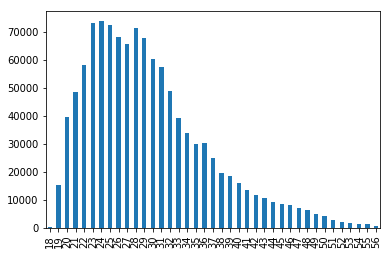

In [316]:
df['age'].value_counts().sort_index().plot(kind='bar',use_index=True)

In [317]:
age_kmeans = KMeans(n_clusters=8, random_state=2019).fit(df[['age']])

In [318]:
df['age_label'] = age_kmeans.labels_

In [319]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std,due_amt_max,due_amt_min,due_amt_median,due_amt_mean,due_amt_sum,due_amt_std,due_amt_skew,due_amt_kurt,due_amt_ptp,age_label
0,3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0,28.0,3.520766,1.0,3.520766,NaN,NaN,3.520766,3.520766,28.0,28.0,28.0,28.0,28.0,NaN,102.1022,102.1022,102.1022,102.102200,102.1022,NaN,NaN,-3.000000,0.0000,0
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0,2.0,2.0,0.0,0.0,2.0,86.234833,1.0,235.094905,397.869326,2.207047,945.006200,10.302392,12.0,0.0,1.0,16.0,3.2,4.969909,945.0062,133.9311,133.9311,321.100800,1605.5040,352.933682,2.113048,0.126236,811.0751,6
2,2355665,404196,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0,3.0,3.0,0.0,0.0,24.0,12.317080,0.5,-45.081960,81.174501,NaN,12.317080,-102.481000,24.0,-1.0,11.5,23.0,11.5,17.677670,307.9270,102.4810,205.2040,205.204000,410.4080,145.272260,NaN,-2.000000,205.4460,7
3,1994522,342769,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.

In [320]:
age_groups = df.groupby('age_label',as_index=False)

In [321]:
# 各组的'early_repay_days_mean'统计信息
df = df.merge(age_groups['early_repay_days_mean'].agg({
    'early_repay_days_mean_age_mean':'mean', 'early_repay_days_mean_age_std':'std'
}), on='age_label', how='left')

In [322]:
# 各组的'early_repay_days_median'统计信息
df = df.merge(age_groups['early_repay_days_median'].agg({
    'early_repay_days_median_age_mean':'mean', 'early_repay_days_median_age_std':'std'
}), on='age_label', how='left')

In [323]:
# 各组的'hist_principal_mean'统计信息
df = df.merge(age_groups['hist_principal_mean'].agg({
    'hist_principal_mean_age_mean':'mean', 'hist_principal_mean_age_std':'std'
}), on='age_label', how='left')

In [324]:
# 各组的'due_amt_mean'统计信息
df = df.merge(age_groups['due_amt_mean'].agg({
    'due_amt_mean_age_mean':'mean', 'due_amt_mean_age_std':'std'
}), on='age_label', how='left')

In [325]:
# 各组的'hist_loans'统计信息
df = df.merge(age_groups['hist_loans'].agg({
    'hist_loans_age_mean':'mean', 'hist_loans_age_std':'std'
}), on='age_label', how='left')

In [326]:
# 计算个体值和组统计均值的差值
df['early_repay_days_mean_age_diff'] = df['early_repay_days_mean'] - df['early_repay_days_mean_age_mean']
df['early_repay_days_median_age_diff'] = df['early_repay_days_median'] - df['early_repay_days_median_age_mean']
df['hist_principal_mean_age_diff'] = df['hist_principal_mean'] - df['hist_principal_mean_age_mean']
df['due_amt_mean_age_diff'] = df['due_amt_mean'] -df['due_amt_mean_age_mean']
df['hist_loans_age_diff'] = df['hist_loans'] -df['hist_loans_age_mean']

In [327]:
del df['age_label']

# 根据hist_loans聚合

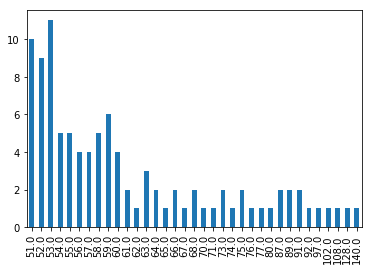

In [328]:
df[df['hist_loans']>50]['hist_loans'].value_counts().sort_index().plot(kind='bar',use_index=True)

In [329]:
hist_loans_kmeans = KMeans(n_clusters=8, random_state=2019).fit(df[['hist_loans']])

In [330]:
df['hist_loans_label'] = hist_loans_kmeans.labels_

In [331]:
hist_loans_groups = df.groupby('hist_loans_label',as_index=False)

In [332]:
# 各组的'early_repay_days_mean'统计信息
df = df.merge(hist_loans_groups['early_repay_days_mean'].agg({
    'early_repay_days_mean_hist_mean':'mean', 'early_repay_days_mean_hist_std':'std'
}), on='hist_loans_label', how='left')

In [333]:
# 各组的'early_repay_days_median'统计信息
df = df.merge(hist_loans_groups['early_repay_days_median'].agg({
    'early_repay_days_median_hist_mean':'mean', 'early_repay_days_median_hist_std':'std'
}), on='hist_loans_label', how='left')

In [334]:
# 计算个体值和组统计均值的差值
df['early_repay_days_mean_hist_diff'] = df['early_repay_days_mean'] - df['early_repay_days_mean_hist_mean']
df['early_repay_days_median_hist_diff'] = df['early_repay_days_median'] - df['early_repay_days_median_hist_mean']

In [335]:
del df['hist_loans_label']

# 处理类别特征和日期

In [336]:
cate_cols = ['gender', 'cell_province', 'id_province', 'id_city']

In [337]:
# 这个lgb应该有参数可以直接传 lgb.train(categorical_feature=cate_cols)
for f in cate_cols:
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique())))).astype('int32')

In [338]:
date_cols = ['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date']

In [339]:
for f in date_cols:
    if f in ['reg_mon', 'info_insert_date', 'tag_insert_date']:
        df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    if f in ['auditing_date', 'due_date', 'info_insert_date', 'tag_insert_date']:
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek

In [340]:
df.drop(columns=date_cols, axis=1, inplace=True)

In [341]:
df['big_month'] = df['auditing_date_month'].apply(lambda x: 1 if x in [1,3,5,7,8,10,12] else 0)
df['February'] = df['auditing_date_month'].apply(lambda x: 1 if x==2 else 0)

In [342]:
# one-hot encoding for tags
df['taglist'] = df['taglist'].astype('str').apply(lambda x: x.strip().replace('|', ' ').strip())

In [343]:
vectorizer = CountVectorizer(min_df=10, max_df=0.9)
tag_cv = vectorizer.fit_transform(df['taglist'])

In [344]:
del df['user_id'], df['listing_id'], df['taglist']

In [345]:
# 也可以用lgb.train(categorical_features=cate_cols)
df = pd.get_dummies(df, columns=cate_cols)
df = pd.get_dummies(df, columns=cate_cols2)

# 训练模型

In [346]:
feature_name = np.concatenate((df.keys(),vectorizer.get_feature_names()))

In [347]:
df_sp = sparse.hstack((df.values, tag_cv), format='csr', dtype='float32')

In [348]:
train_values, test_values = df_sp[:train_num], df_sp[train_num:]

In [358]:
def add_1_month(s):
    s = s.strftime('%F')
    y, m, d = str(s).split('-')
    y = int(y)
    m = int(m)
    d = int(d)
    m = m + 1
    if m == 13:
        m = 1
        y = y + 1
    if m in [4,6,9,11]:
        if d == 31:
            d = 30
    if m == 2:
        if d in [29, 30, 31]:
            if y in [2012, 2016]:
                d = 29
            else:
                d = 28
    return datetime.datetime.strptime(str(y)+'-'+str(m)+'-'+str(d), '%Y-%m-%d')

In [495]:
# 把整个验证集看作一个资产组合计算rmse
def new_rmse(val_df, prob_oof):
    val_df2=val_df[['listing_id']].copy()
    # 制作一个类似submission的表
    val_df['pre_repay_date'] = val_df['auditing_date']
    val_df_temp = val_df.copy()
    for i in range(31):
        val_df_temp['pre_repay_date'] = plus_1_day(val_df_temp['pre_repay_date'])
        val_df= pd.concat([val_df, val_df_temp],axis=0, ignore_index=True)
    val_df = val_df[val_df['pre_repay_date']<=val_df['due_date']]
    
    prob_cols = ['prob_{}'.format(i) for i in range(33)]
    for i, f in enumerate(prob_cols):
        val_df2[f] = prob_oof[:, i]
    val_df = val_df.merge(val_df2, on='listing_id', how='left')
    val_df['days'] = (val_df['due_date'] - val_df['pre_repay_date']).dt.days
    val_prob = val_df[prob_cols].values
    val_labels = val_df['days'].values
    val_prob = [val_prob[i][val_labels[i]] for i in range(val_prob.shape[0])]
    
    val_df['pre_repay_amt'] = val_df['due_amt'] * val_prob
    val_df['repay_amt'] = val_df[val_df['pre_repay_date']==val_df['repay_date']]['due_amt']
    groups_date = val_df.groupby('pre_repay_date')
    repay_amt = groups_date.repay_amt.sum()
    pre_repay_amt = groups_date.pre_repay_amt.sum()
    days = groups_date.ngroups
    
    return math.sqrt(((repay_amt-pre_repay_amt)**2).sum()/days)

49323.40118379324

In [484]:
val_df[val_df['listing_id']==2904314]

,listing_id,auditing_date,due_date,due_amt,repay_date,pre_repay_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32
164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-05,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
1000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-06,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
2000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-07,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
3000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-08,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
4000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-09,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
5000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-10,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
6000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-11,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
7000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-12,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
8000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-13,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593
9000164,2904314,2018-04-05,2018-05-05,1143.5655,2018-04-06,2018-04-14,0.264444,0.106834,0.052082,0.054679,0.026705,0.02053,0.021243,0.016199,0.016695,0.018478,0.007716,0.010174,0.008315,0.010093,0.009119,0.012882,0.010377,0.010598,0.006205,0.006741,0.012534,0.006382,0.005827,0.008274,0.007212,0.007916,0.010049,0.012045,0.016449,0.03661,0.106932,0.000065,0.079593


In [446]:
val_df.shape

(30452750, 6)

In [349]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_leaves=70,
    reg_alpha=3,
    reg_lambda=5,
    max_depth=7,
    n_jobs=87,
    learning_rate=0.1,
    n_estimators=5000,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.77,
    random_state=2019,
    min_child_weight=4,
    min_child_samples=5,
    min_split_gain=0
)
amt_oof = np.zeros(train_num)
prob_oof = np.zeros((train_num, 33))
test_pred_prob = np.zeros((test_values.shape[0], 33))
for i, (trn_idx, val_idx) in enumerate(skf.split(train_values, clf_labels)):
    print(i, 'fold...')
    t = time.time()

    trn_x, trn_y = train_values[trn_idx], clf_labels[trn_idx]
    val_x, val_y = train_values[val_idx], clf_labels[val_idx]
    val_repay_amt = amt_labels[val_idx]
    val_due_amt = train_due_amt_df[val_idx]
    val_df = train_df[['listing_id','auditing_date','due_date','due_amt','repay_date']].iloc[val_idx]

    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        early_stopping_rounds=50, verbose=5, feature_name=list(feature_name)
    )
    # shape = (-1, 33)
    val_pred_prob_everyday = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    prob_oof[val_idx] = val_pred_prob_everyday
    val_pred_prob_today = [val_pred_prob_everyday[i][val_y[i]] for i in range(val_pred_prob_everyday.shape[0])]
    val_pred_repay_amt = val_due_amt * val_pred_prob_today
    print('val rmse:', np.sqrt(mean_squared_error(val_repay_amt, val_pred_repay_amt)))
    print('val mae:', mean_absolute_error(val_repay_amt, val_pred_repay_amt))
    print('val new rmse:', new_rmse(val_df, val_pred_prob_everyday))
    amt_oof[val_idx] = val_pred_repay_amt
    test_pred_prob += clf.predict_proba(test_values, num_iteration=clf.best_iteration_) / skf.n_splits

    print('runtime: {}\n'.format(time.time() - t))

print('\ncv rmse:', np.sqrt(mean_squared_error(amt_labels, amt_oof)))
print('cv mae:', mean_absolute_error(amt_labels, amt_oof))
print('cv logloss:', log_loss(clf_labels, prob_oof))
print('cv acc:', accuracy_score(clf_labels, np.argmax(prob_oof, axis=1)))

0 fold...
Training until validation scores don't improve for 50 rounds.
[5]	valid_0's multi_logloss: 2.68791	valid_1's multi_logloss: 2.69262
[10]	valid_0's multi_logloss: 2.44368	valid_1's multi_logloss: 2.45253
[15]	valid_0's multi_logloss: 2.31295	valid_1's multi_logloss: 2.32601
[20]	valid_0's multi_logloss: 2.23418	valid_1's multi_logloss: 2.25162
[25]	valid_0's multi_logloss: 2.18354	valid_1's multi_logloss: 2.20533
[30]	valid_0's multi_logloss: 2.14931	valid_1's multi_logloss: 2.17577
[35]	valid_0's multi_logloss: 2.12527	valid_1's multi_logloss: 2.1564
[40]	valid_0's multi_logloss: 2.10758	valid_1's multi_logloss: 2.1435
[45]	valid_0's multi_logloss: 2.09401	valid_1's multi_logloss: 2.13476
[50]	valid_0's multi_logloss: 2.08317	valid_1's multi_logloss: 2.12879
[55]	valid_0's multi_logloss: 2.07417	valid_1's multi_logloss: 2.12466
[60]	valid_0's multi_logloss: 2.06642	valid_1's multi_logloss: 2.12175
[65]	valid_0's multi_logloss: 2.05962	valid_1's multi_logloss: 2.11969
[70]	val

[160]	valid_0's multi_logloss: 1.97773	valid_1's multi_logloss: 2.11704
[165]	valid_0's multi_logloss: 1.97427	valid_1's multi_logloss: 2.11707
[170]	valid_0's multi_logloss: 1.97086	valid_1's multi_logloss: 2.1171
[175]	valid_0's multi_logloss: 1.9674	valid_1's multi_logloss: 2.11711
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 2.00009	valid_1's multi_logloss: 2.11697
val rmse: 468.6614059456699
val mae: 289.6424461111692
runtime: 713.4973437786102

3 fold...
Training until validation scores don't improve for 50 rounds.
[5]	valid_0's multi_logloss: 2.68772	valid_1's multi_logloss: 2.69284
[10]	valid_0's multi_logloss: 2.44366	valid_1's multi_logloss: 2.45327
[15]	valid_0's multi_logloss: 2.31282	valid_1's multi_logloss: 2.32678
[20]	valid_0's multi_logloss: 2.23401	valid_1's multi_logloss: 2.2525
[25]	valid_0's multi_logloss: 2.18337	valid_1's multi_logloss: 2.20633
[30]	valid_0's multi_logloss: 2.14919	valid_1's multi_logloss: 2.17678
[35]	valid_0's multi_logloss

In [ ]:
# # 原本的输出
# prob_cols = ['prob_{}'.format(i) for i in range(33)]
# for i, f in enumerate(prob_cols):
#     sub[f] = test_pred_prob[:, i]
# sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])
# sub_example = sub_example.merge(sub, on='listing_id', how='left')
# sub_example['days'] = (sub_example['repay_date'] - sub_example['auditing_date']).dt.days
# # shape = (-1, 33)
# test_prob = sub_example[prob_cols].values
# test_labels = sub_example['days'].values
# test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]
# sub_example['repay_amt'] = sub_example['due_amt'] * test_prob
# sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv('sub.csv', index=False)

In [179]:
import pickle
with open("test_pred_prob7.pkl", 'wb') as f:
    pickle.dump(test_pred_prob, f)

In [354]:
prob_cols = ['prob_{}'.format(i) for i in range(33)]

In [355]:
for i, f in enumerate(prob_cols):
    sub[f] = test_pred_prob[:, i]

In [356]:
sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])

In [357]:
sub_example = sub_example.merge(sub, on='listing_id', how='left')

In [360]:
sub_example['due_date'] = sub_example['auditing_date'].parallel_apply(add_1_month)

In [361]:
sub_example.head()

,listing_id,repay_amt,repay_date,user_id,auditing_date,due_amt,due_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32
0,5431438,4.3309,2019-03-12,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278
1,5431438,4.3309,2019-03-13,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278
2,5431438,4.3309,2019-03-14,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278
3,5431438,4.3309,2019-03-15,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278
4,5431438,4.3309,2019-03-16,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278


In [362]:
sub_example['days'] = (sub_example['due_date'] - sub_example['repay_date']).dt.days

In [368]:
sub_example.head(30)

,listing_id,repay_amt,repay_date,user_id,auditing_date,due_amt,due_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32,days
0,5431438,0.062829,2019-03-12,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,31
1,5431438,0.053283,2019-03-13,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,30
2,5431438,0.060094,2019-03-14,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,29
3,5431438,0.060552,2019-03-15,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,28
4,5431438,0.049423,2019-03-16,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,27
5,5431438,0.062731,2019-03-17,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,26
6,5431438,0.061163,2019-03-18,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,25
7,5431438,0.062895,2019-03-19,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,24
8,5431438,0.062519,2019-03-20,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,23
9,5431438,0.067666,2019-03-21,498765,2019-03-12,138.5903,2019-04-12,0.787373,0.059364,0.021901,0.016094,0.00886,0.005938,0.003878,0.003205,0.003865,0.002364,0.001662,0.001327,0.00175,0.001226,0.000857,0.000694,0.00078,0.000724,0.000794,0.000642,0.000543,0.00053,0.000488,0.000451,0.000454,0.000441,0.000453,0.000357,0.000437,0.000434,0.000384,0.000453,0.071278,22


In [364]:
test_prob = sub_example[prob_cols].values

In [365]:
test_labels = sub_example['days'].values

In [366]:
test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]

In [367]:
sub_example['repay_amt'] = sub_example['due_amt'] * test_prob

In [369]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv", index=False)

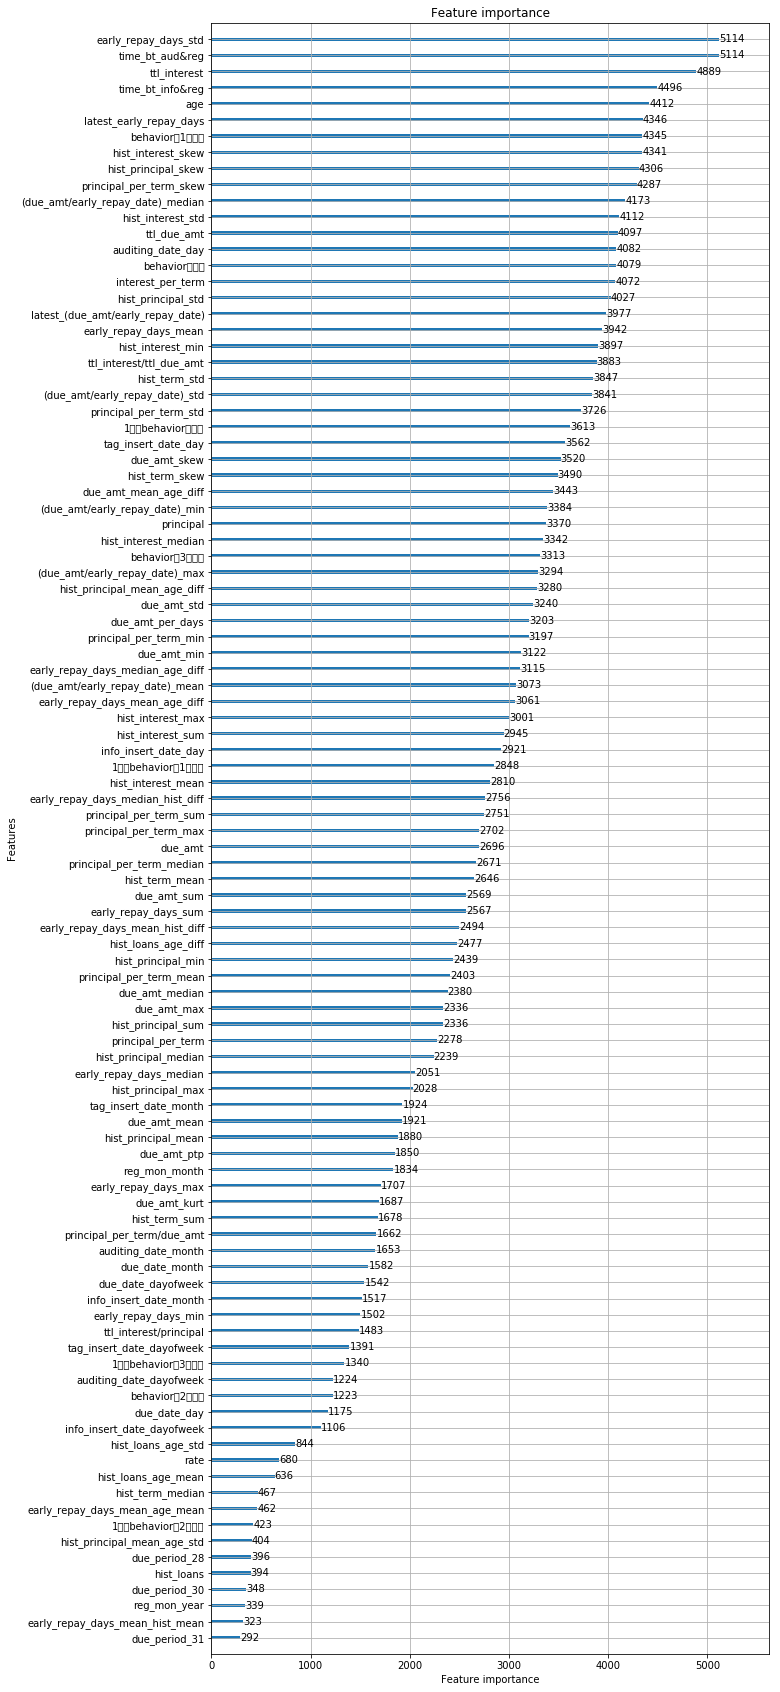

In [353]:
lgb.plot_importance(clf, max_num_features=100,figsize=(10,30))

In [ ]:
sub_example2 = sub_example.copy()

In [173]:
sub_example2['prob'] = test_prob

In [174]:
threshold_up = 0.57
id_with_highpro = sub_example[sub_example2['prob']>=threshold_up]['listing_id']

In [175]:
sub_example2.loc[sub_example2['listing_id'].isin(id_with_highpro.values),'repay_amt']=0

In [176]:
sub_example2['repay_amt']= sub_example2.apply(lambda x:x['repay_amt'] if x['prob']<threshold_up else x['due_amt'],axis=1)

In [177]:
sub_example2[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_0_{threshold_up}.csv", index=False)

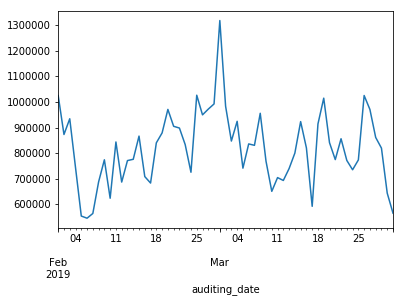

In [378]:
sub_example.groupby('auditing_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

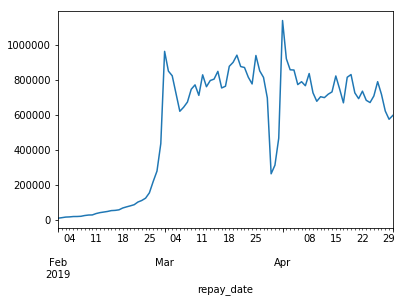

In [496]:
sub_example.groupby('repay_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

def alter(df, date, a):
    """
    data就是要增加的日期
    a就是这天增加的比例
    """
    if date not in df['repay_date'].values:
        return df
    else:
        dates = df['repay_date'].tolist()
        dates.remove(date)
        df = df.set_index('repay_date')
        b = df.loc[date, 'repay_amt'] * a
        df.loc[date, 'repay_amt'] += b
        df.loc[dates, 'repay_amt'] -= b / len(dates)
        df.reset_index(inplace=True)
        return df

sub_example_1 = sub_example.copy()

sub_example_1['repay_date']=sub_example_1['repay_date'].astype(str)

sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-29", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-30", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-31", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]

sub_example_1.to_csv("sub_ex.csv",index=False)